In [ ]:
##OG material:Multiclass Food Classification using TensorFlow by Avinash Kappa
##@Author Roger Luo
##Finetuned OG material to work on entire dataset
##its a fairly large dataset takes time
##
##

In [ ]:
#imports
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.0
/device:GPU:0


In [ ]:
#if the gpu is not at 0 mb used

#!kill -9 -1

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=b55cbbbed6c5d34ea5474b5d2cd7b973047ac58936707ce0b9f0949fa295766a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.2 GB  | Proc size: 1.1 GB
GPU RAM Free: 14852MB | Used: 227MB | Util   2% | Total 15079MB


In [ ]:
#run to download and extract data
print("Downloading the data...")
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
print("Dataset downloaded!")
print("Extracting data..")
!tar xzvf food-101.tar.gz
print("Extraction done!")

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [ ]:
#check dataset items
!ls food-101/


images	license_agreement.txt  meta  README.txt


In [ ]:
os.listdir('food-101/images')

['greek_salad',
 'bibimbap',
 'poutine',
 'red_velvet_cake',
 'spaghetti_carbonara',
 'beef_tartare',
 'paella',
 'chicken_curry',
 'beet_salad',
 'eggs_benedict',
 'lasagna',
 'cup_cakes',
 'fish_and_chips',
 'hamburger',
 'ramen',
 'foie_gras',
 'deviled_eggs',
 'beignets',
 'sashimi',
 'risotto',
 'cheesecake',
 'dumplings',
 'beef_carpaccio',
 'apple_pie',
 'falafel',
 'pad_thai',
 'crab_cakes',
 'cheese_plate',
 'chocolate_mousse',
 'french_onion_soup',
 'carrot_cake',
 'escargots',
 'fried_rice',
 'tacos',
 'gnocchi',
 'guacamole',
 'filet_mignon',
 'hot_and_sour_soup',
 'peking_duck',
 'waffles',
 'churros',
 'prime_rib',
 'frozen_yogurt',
 'club_sandwich',
 'baby_back_ribs',
 'scallops',
 'chocolate_cake',
 'creme_brulee',
 'miso_soup',
 'seaweed_salad',
 'garlic_bread',
 'clam_chowder',
 'chicken_wings',
 'breakfast_burrito',
 'tiramisu',
 'fried_calamari',
 'macaroni_and_cheese',
 'tuna_tartare',
 'caprese_salad',
 'samosa',
 'ice_cream',
 'gyoza',
 'hot_dog',
 'bruschetta',


In [ ]:
#adjust to directory contents are stored in; this is just the directory for google colab
os.listdir('/content/food-101/meta')


['test.txt',
 'train.txt',
 'classes.txt',
 'test.json',
 'labels.txt',
 'train.json']

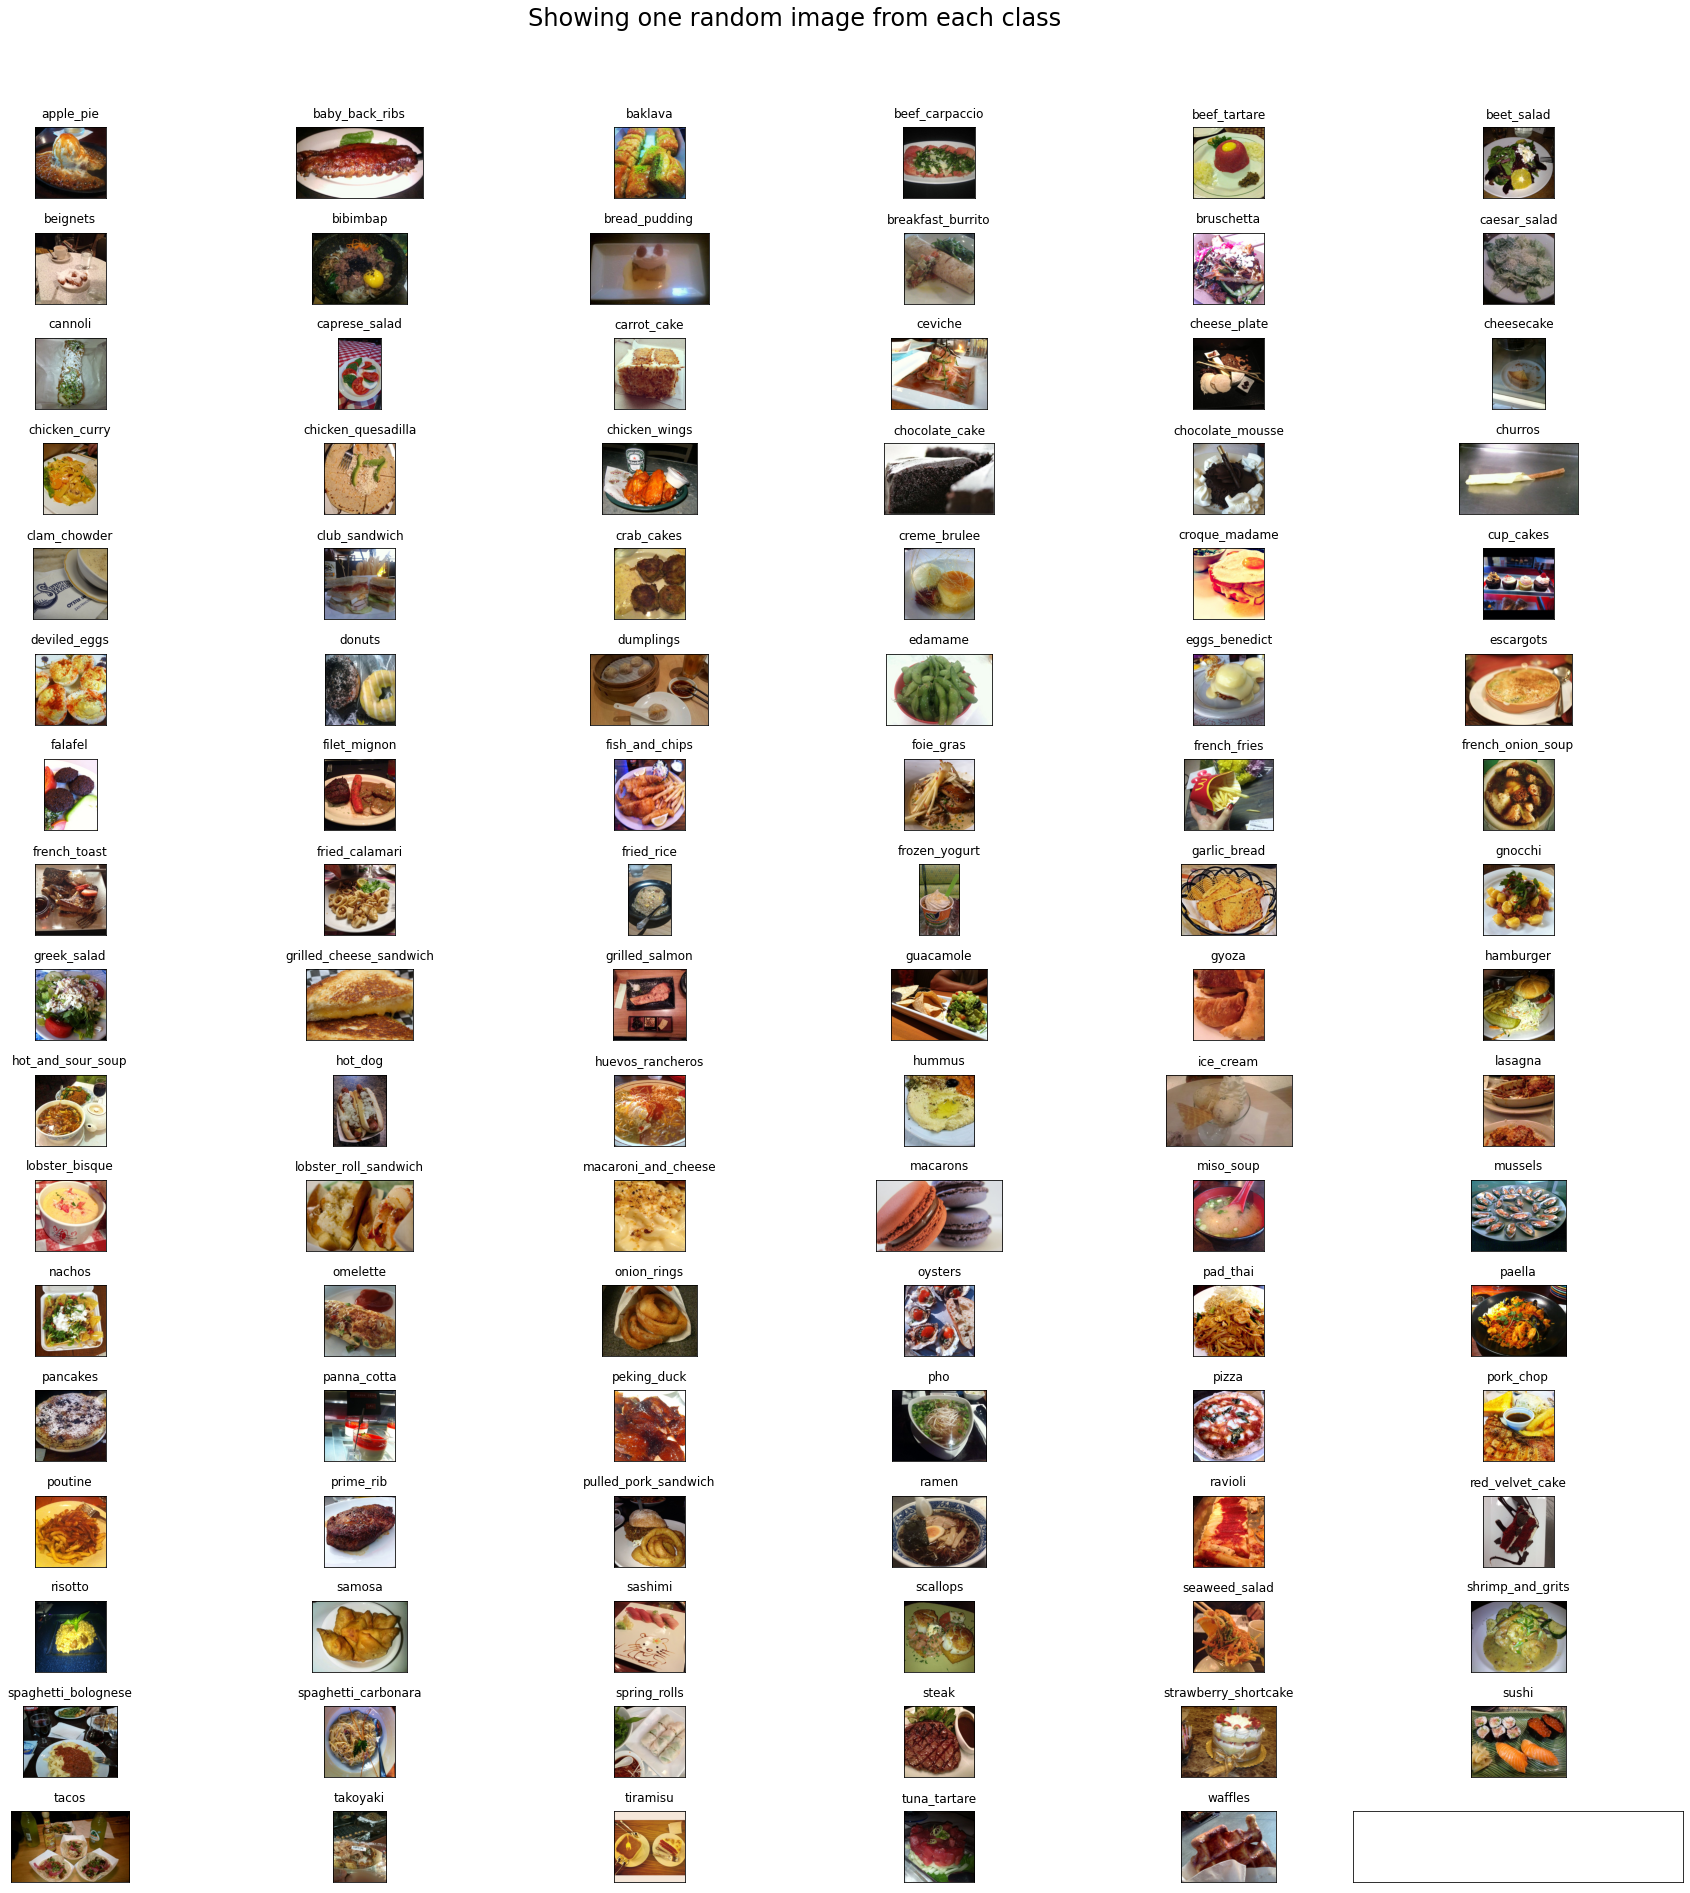

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
#taking out .DS_store? mby only in kaggle
foods_sorted


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
#clear and define attributes for model for use on miniset
K.clear_session()
n_classes = 101 #changed to finetune for whole dataset
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 75750 #adjusted to full dataset
nb_validation_samples = 25250
batch_size = 64

In [ ]:
#create train and validation tipeline
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [ ]:
# import tensorflow.keras.applications
# from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# transfer learning from tensorflows InceptionV3 model
inception = InceptionV3(weights='imagenet', include_top=False)
# additonal layers
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:

predictions = Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

#model factors and compiling
model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

#fit the model with the data using fit_generator to utilize the pipelines created
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=12,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
1183/1183 [==============================] - 2080s 2s/step - loss: 5.1915 - accuracy: 0.0160 - val_loss: 4.9874 - val_accuracy: 0.0681

Epoch 00001: val_loss improved from inf to 4.98742, saving model to best_model_3class.hdf5
Epoch 2/12
1183/1183 [==============================] - 2044s 2s/step - loss: 4.9501 - accuracy: 0.0702 - val_loss: 4.5486 - val_accuracy: 0.1958

Epoch 00002: val_loss improved from 4.98742 to 4.54857, saving model to best_model_3class.hdf5
Epoch 3/12
1183/1183 [==============================] - 2030s 2s/step - loss: 4.5381 - accuracy: 0.1661 - val_loss: 3.9271 - val_accuracy: 0.3142

Epoch 00003: val_loss improved from 4.54857 to 3.92708, saving model to best_model_3class.hdf5
Epoch 4/12
1183/1183 [==============================] - 2013s 2s/step - loss: 4.0322 - accuracy: 0.2606 - val_loss: 3.3669 - val_accuracy: 0.4047

Epoch 00004: val_loss improved from 3.92708 to 3.36693, saving model to best_model_3class.hdf5
Epoch 5/12
1183/1183 [==============

In [ ]:
#map the indicies
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

KeyError: ignored

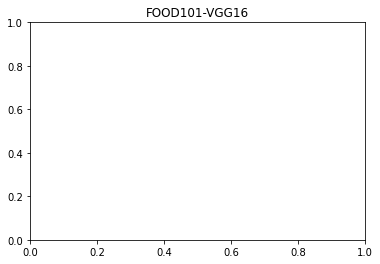

In [ ]:
#visualizations
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()
plot_accuracy(history,'FOOD101-VGG16')
plot_loss(history,'FOOD101-VGG16')

In [ ]:
#loading and using the model to predict things
import pandas as pd
K.clear_session()
model_best=load_model('/best_model_3class.hdf5',compile=False)
food_list=foods_sorted
recipes=pd.read_excel('Food_rep_man.xlsx')
recipes.iloc[0]['Ingredients']
print(foods_sorted)

NameError: ignored

In [ ]:
#preproccessing and predicting images
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    ings=recipe(pred_value)
    print(ings)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
def recipe(pred):
    index= food_list.index(pred)
    ings =recipes.iloc[index]['Ingredients'].replace('\n','').replace('"','').split(',')
    for i in range(0,len(ings)):
      ings[i]=ings[i].strip()
    return ings


['3 large heirloom tomatoes (about 2 1/2 pounds)', 'cored', '1 large red onion', '1 serrano chile pepper', 'stemmed', '1 cup fresh cilantro (leaves and stems)', '1 tablespoon Mexican beer (drink the rest!)', 'Juice of 1 lime', 'Kosher salt and freshly ground pepper', '6 to 8 ounces nduja (soft Italian salami; available at boccalone.com)', '1 8-to-10-ounce bag white corn tortilla chips', '1 bunch scallions', 'thinly sliced', '2 cups canned pinto beans', 'drained and rinsed', 'Finely grated zest of 1 lime', '12 radishes', 'thinly sliced', '1 cup queso fresco', '1 cup fresh corn kernels', '2 tablespoons pickled jalapeno slices', 'drained', 'or more to taste', '2 hass avocados', '1/2 cup fresh cilantro leaves']


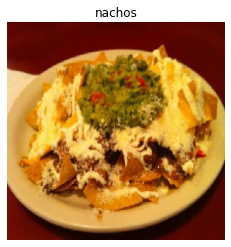

['1 teaspoon each coriander seeds', 'cumin seeds', 'mustard seeds', '2 cups basmati rice', 'prepared according to package directions', '3 tablespoons vegetable or canola oil', '3 turns of the pan', '1 1/3 to 1 1/2 pounds chicken breast tenders', 'diced', '2 to 4 cloves garlic', 'minced', 'mild to extra spicy', '1 to 2 inches fresh ginger root', 'minced or grated', 'mild to extra spicy', '1 large yellow skinned onion', 'peeled and chopped', '1 can chicken broth', 'about 2 cups', '2 tablespoons curry paste', 'mild or hot', '1/3 to 1/2 cup mincemeat', 'Coarse salt', '2 tablespoons flour', '4 scallions', 'chopped', '1 cup toasted coconut', '1/2 cup sliced almonds or Spanish peanuts', '1 cup prepared mango chutney', '1 /4 cup finely chopped cilantro leaves']


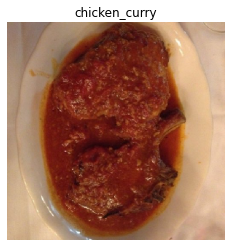

['Butter and flour for cake pans', '2 cups sifted cake flour', '1 teaspoon ground cinnamon', '1 1/2 teaspoons baking powder', '1 teaspoon baking soda', '1/2 teaspoon salt', '1/2 cup unsweetened cocoa (Dutch process', 'European style)', '1/4 pound unsalted butter', 'at room temperature', '1 1/2 cups sugar', '3 eggs', 'lightly beaten', '1 teaspoon vanilla', '1 teaspoon vinegar (any kind)', '1 cup buttermilk', '1 tablespoon red food coloring dissolved in 2 tablespoons boiling water', '1 recipe boiled icing (see below)', '1/3 cup flaked dried coconut', 'optional']


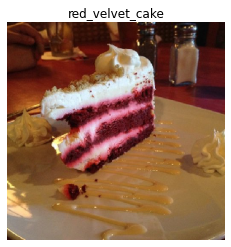

In [ ]:
images=[]
images.append('/content/food-101/images/nachos/103312.jpg')
images.append('/content/food-101/images/pork_chop/1012227.jpg')
images.append('/content/food-101/images/red_velvet_cake/1023987.jpg')
predict_class(model_best, images, True)

In [ ]:
#Conitue training model
#loading and using the model to predict things
import pandas as pd
K.clear_session()
model_best=load_model('/12hours_model.hdf5',compile=False)


In [ ]:
food_list=['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']
recipes=pd.read_excel('/Food_rep_man (1).xlsx')
recipes.iloc[0]['Ingredients']
print(food_list)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
#continueing to train the model
model_best.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')
model_best.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=12,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
1183/1183 [==============================] - 2183s 2s/step - loss: 1.4609 - accuracy: 0.7379 - val_loss: 1.2377 - val_accuracy: 0.7835

Epoch 00001: val_loss improved from inf to 1.23770, saving model to best_model_3class.hdf5
Epoch 2/12
1183/1183 [==============================] - 2082s 2s/step - loss: 1.4283 - accuracy: 0.7470 - val_loss: 1.2182 - val_accuracy: 0.7861

Epoch 00002: val_loss improved from 1.23770 to 1.21820, saving model to best_model_3class.hdf5
Epoch 3/12
1183/1183 [==============================] - 2066s 2s/step - loss: 1.3907 - accuracy: 0.7505 - val_loss: 1.2026 - val_accuracy: 0.7883

Epoch 00003: val_loss improved from 1.21820 to 1.20259, saving model to best_model_3class.hdf5
Epoch 4/12
1183/1183 [==============================] - 2064s 2s/step - loss: 1.3684 - accuracy: 0.7577 - val_loss: 1.1795 - val_accuracy: 0.7918

Epoch 00004: val_loss improved from 1.20259 to 1.17951, saving model to best_model_3class.hdf5
Epoch 5/12
1183/1183 [==============